In [1]:
import datetime
import os
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

/home/jeet/my_Projects/all/myvenv/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
def download_data(verbose=True):
	"""
	Fetching the data from public servers

	Parameters
	----------
	verbose: boolean

	Returns
	-------
	trips: list of dicts
        Each distionary has a 'dep' and 'arr' key, indicating the
        departure and arrival date-times for each trip
	"""
	#Harvard Square. Red - line stop. Outbound
	hardvard_stop_id = '70068'
	#JFK/UMass. Red - line stop. Inbound
	jfk_stop_id = '70086'

	#gather trip data
	#assuming that we want to reach Harvard Sq at 9 am
	#we consider a safe margin around it
	start_time = datetime.time(7,0)
	end_time = datetime.time(10,0)
	start_date = datetime.date(2015,5,1) #May 2015
	end_date = datetime.date(2018,5,1) #May 2018

	#Constructing URL Partwise
	#Refer : https://cdn.mbta.com/sites/default/files/developers/2018-10-30-mbta-realtime-performance-api-documentation-version-0-9-5-public.pdf

	base_ = "http://realtime.mbta.com/developer/api/v2.1/traveltimes"
	apikey_ = "?api_key=wX9NwuHnZU2ToO7GmGR9uw"
	format_ = "&format=json"
	from_stop_ = "&from_stop=" + str(jfk_stop_id)
	to_stop_ = "&to_stop=" + str(hardvard_stop_id)
	
	#Cycle through all days
	dayi = 0
	trips = []
	while True:
		check_date = start_date + datetime.timedelta(days=dayi)
		if(check_date > end_date):
			break
		#Build the query
		temp_from_time = datetime.datetime.combine(check_date, start_time)
		temp_to_time = datetime.datetime.combine(check_date, end_time)
		from_datetime = "&from_datetime=" + str(int(temp_from_time.timestamp()))
		to_datetime = "&to_datetime=" + str(int(temp_to_time.timestamp()))

		SRequest = "".join([
			base_,
			apikey_,
			format_,
			from_stop_,
			to_stop_,
			from_datetime,
			to_datetime
			])
		response = requests.get(SRequest)
		response_json = response.json()
		for trip in response_json['travel_times']:
			trips.append({
				'dep':datetime.datetime.fromtimestamp(float(trip["dep_dt"])),
				'arr':datetime.datetime.fromtimestamp(float(trip["arr_dt"]))
			})
		if verbose:
			print(check_date,':',len(response_json["travel_times"]), " trips")
		dayi += 1
	return trips

In [3]:
def calculate_arrival_times(trips, harvard_walk=4, jfk_walk=6, target_hour=9, target_minute=0, train_dep_min=-60, train_dep_max=0, debug=False):
    """
    Based on the downloaded trips data, calculate the arrival times
    that each possible departure time would result in.
    The kwargs above default to our specific use case (work starts
    at 9:00, it takes 6 minutes to walk to JFK, and it takes
    4 minutes to walk from Harvard Square to work)
    Parameters
    ----------
    harvard_walk, jfk_walk: int
        The time in minutes it takes to make these walks.
    trips: DataFrame
    target_hour, target_minute: int
        The time work starts is target_hour:target_minute.
    train_dep_min, train_dep_max: int
        The time, relative to the target, in minutes when the train departs
        from JFK. Negative number means minutes **before** the target.
        Min and max define the time window under consideration.
    debug: boolean
    """
    minutes_per_hour = 60
    date_format = '%Y-%m-%d'
    trips_expanded = []
    for raw_trip in trips:
        rel_dep = (
            minutes_per_hour * (raw_trip['dep'].hour - target_hour) +
            (raw_trip['dep'].minute - target_minute))
        rel_arr = (
            minutes_per_hour * (raw_trip['arr'].hour - target_hour) +
            (raw_trip['arr'].minute - target_minute))

        if rel_dep > train_dep_min and rel_dep <= train_dep_max:
            new_trip = {
                'departure': rel_dep,
                'arrival': rel_arr,
                'date': raw_trip['dep'].date(),
            }
            trips_expanded.append(new_trip)

    trips_df = pd.DataFrame(trips_expanded)
    return trips_df

In [4]:
def load_data():
    """
    Try to load the dataset from the local system
    Otherwise download it and save it as pickle
    """
    file_name = './dataset.pkl'
    try:
        trips = list(pd.read_pickle(file_name))
    except Exception:
        print("Dataset Not Found In Current Working Directory...\nPress ENTER To Start Downloading Now...")
        nothing = input('')
        trips = download_data()
        dataset = pd.Series(trips)
        dataset.to_pickle(file_name)
    return trips

In [5]:
#if __name__=='__main__':
os.environ['TZ'] = 'US/Eastern'
time.tzset()
trips = load_data() #loads data

In [6]:
df = calculate_arrival_times(trips)

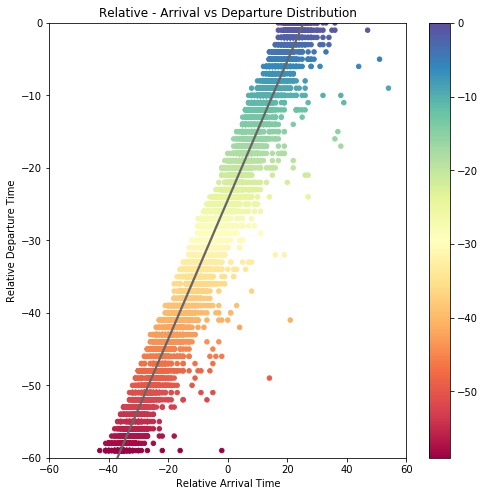

In [10]:
#EDA

plt.figure(figsize=(8,8))
points = plt.scatter(df.arrival, df.departure,c=df.departure, s=20, cmap="Spectral")
plt.colorbar(points)
#set limits
plt.xlim(-60, 60)
plt.ylim(-60, 0)

#build the plot
plot = sb.regplot("arrival", "departure", data=df, scatter=False, color=".4")
plot = plot.set(title='Relative - Arrival vs Departure Distribution', ylabel='Relative Departure Time', xlabel='Relative Arrival Time')